In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

Using TensorFlow backend.


# Learning choice functions

We apply our first-aggregate-then-evaluate (FATE) architecture to the problem of learning choice functions.
We will first start to investigate latent linear functions to sanity check our implementation.
Then we will move to the problem of learning Pareto-optimality.
## Learning a latent linear function


In [2]:
data_seed = 126
weight_seed = 35
n_train = 100000
n_test = 100000
n_features = 2
n_objects = 6
n_rep_units = 5
threshold = 1

In [3]:
from sklearn.utils import check_random_state
def make_latent_linear_choices(n_inst=10000, n_features=2, n_objects=6,
                               n_rep_units=5, threshold=0.,
                               data_seed=None, weight_seed=None):
    rand = check_random_state(data_seed)
    ranw = check_random_state(weight_seed)
    X = rand.uniform(-1, 1, size=(n_inst, n_objects, n_features))
    W_rep = ranw.randn(n_features, n_rep_units)
    rep = X.dot(W_rep).mean(axis=-2)
    w_join = ranw.randn(n_features + n_rep_units)
    joint_matrix = np.empty((n_objects, n_inst, n_features + n_rep_units),
                            dtype=np.float32)
    for i in range(n_objects):
        joint_matrix[i] = np.concatenate((X[:, i], rep), axis=-1)
    scores = joint_matrix.dot(w_join)
    Y = scores > threshold
    return X, Y.T, W_rep, w_join

In [4]:
X_train, Y_train, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed,
    weight_seed=weight_seed,
    threshold=threshold)
X_test, Y_test, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed+1,
    weight_seed=weight_seed,
    threshold=threshold)
print(Y_train.mean())

0.160225


Since we used only 2 features, we can plot the positive and negative objects of the dataset:

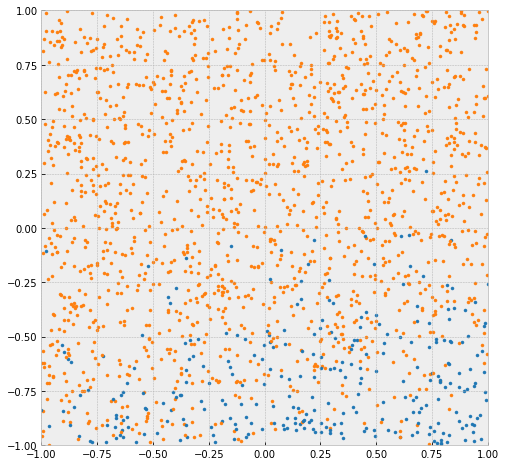

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:300], Y_train[:300])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.')
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.')

In [6]:
from yellowfin import YFOptimizer
from keras.optimizers import TFOptimizer
from keras.metrics import binary_accuracy
opt = TFOptimizer(YFOptimizer(learning_rate=0.1))
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=2,
                          n_hidden_joint_units=32,
                          n_hidden_set_layers=2,
                          n_hidden_set_units=32,
                          optimizer=opt,
                          batch_size=512,
                          metrics=[binary_accuracy])

In [7]:
fate.fit(X_train, Y_train, verbose=True, epochs=200)

Train on 90000 samples, validate on 10000 samples
Epoch 1/200
90000/90000 [==============================] - 5s 57us/step - loss: 1.2031 - binary_accuracy: 0.9211 - val_loss: 0.3515 - val_binary_accuracy: 0.8938
Epoch 2/200
90000/90000 [==============================] - 4s 43us/step - loss: 0.3141 - binary_accuracy: 0.8982 - val_loss: 0.2882 - val_binary_accuracy: 0.8884
Epoch 3/200
90000/90000 [==============================] - 4s 43us/step - loss: 0.2885 - binary_accuracy: 0.8879 - val_loss: 0.2867 - val_binary_accuracy: 0.8892
Epoch 4/200
90000/90000 [==============================] - 4s 42us/step - loss: 0.2879 - binary_accuracy: 0.8879 - val_loss: 0.2866 - val_binary_accuracy: 0.8884
Epoch 5/200
90000/90000 [==============================] - 4s 41us/step - loss: 0.2901 - binary_accuracy: 0.8864 - val_loss: 0.2888 - val_binary_accuracy: 0.8871
Epoch 6/200
90000/90000 [==============================] - 4s 42us/step - loss: 0.2904 - binary_accuracy: 0.8859 - val_loss: 0.2944 - val_bi

KeyboardInterrupt: 

In [153]:
pred = fate.predict(X_test)

In [154]:
from sklearn.metrics import f1_score, accuracy_score
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.9583
Micro F1 measure: 0.9583
Subset Accuracy: 0.9282


## Learning Pareto-Optimality
We now try to solve the problem of predicting the Pareto-optimal set of points $O\subseteq X$.
In other words, it is the set of points which or not dominated by any other point.

Let us plot a small example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

Using TensorFlow backend.


In [2]:
from sklearn.utils import check_random_state
def pareto_front(X, signs=None):
    n_points, n_attributes = X.shape
    if signs is None:
        signs = -np.ones(n_attributes)
    pareto = np.ones(n_points, dtype=bool)
    for i, attr in enumerate(X):
        pareto[i] = np.all(np.any((X*signs[None, :]) <= (attr*signs), axis=1))
    return pareto

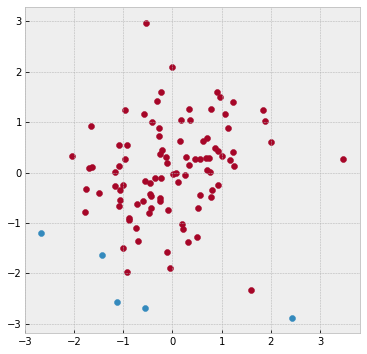

In [3]:
X = np.random.randn(100, 2)
fig, ax = plt.subplots(figsize=(6,6))
pareto = pareto_front(X)
ax.scatter(X[pareto][:, 0], X[pareto][:, 1])
ax.scatter(X[~pareto][:, 0], X[~pareto][:, 1]);

In this example we have to criteria which we want to minimize.
The blue points form the Pareto-front.

In [4]:
from sklearn.utils import check_random_state
def sample_unit_ball(n_inst=10000, n_features=2, rng=None, radius=1.):
    rng = check_random_state(rng)
    X = rng.randn(n_inst, n_features)
    u = rng.uniform(size=n_inst)[:, None]
    X /= np.linalg.norm(X, axis=1, ord=2)[:, None]
    X *= radius * u
    return X
def make_randn_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None, center=0.):
    """Generate random objects from a d-dimensional isometric normal distribution.
    
    This should be the easiest possible Pareto-problem, since the model can learn
    a latent-utility which scores how likely a point is on the front (independent
    of the other points)."""
    rand = check_random_state(data_seed)
    X = rand.randn(n_inst, n_objects, n_features)
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(n_inst):
        Y[i] = pareto_front(X[i])
    return X+center, Y
def make_globular_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None,
                                 cluster_spread=1., cluster_size=10):
    rand = check_random_state(data_seed)
    X = np.empty((n_inst, n_objects, n_features))
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(int(n_inst / cluster_size)):
        center = sample_unit_ball(n_inst=1, n_features=n_features,
                                  rng=rand, radius=cluster_spread)
        x, y = make_randn_pareto_choices(n_inst=cluster_size, n_features=n_features, n_objects=n_objects,
                                         data_seed=rand, center=center)
        X[i*cluster_size:(i+1)*cluster_size] = x
        Y[i*cluster_size:(i+1)*cluster_size] = y
    return X, Y

In [5]:
from csrank import SyntheticIterator
n_inst = 1024
n_objects = 30
n_features = 5
pareto_iter = SyntheticIterator(make_randn_pareto_choices,
                                n_inst=n_inst, n_features=n_features, n_objects=n_objects)

In [6]:
n_train = 100000
n_test = 10000
n_objects = 30
n_features = 2
seed = 123

X_train, Y_train = make_globular_pareto_choices(n_inst=n_train, n_objects=n_objects,
                                             n_features=n_features, data_seed=seed,
                                                cluster_spread=10)
X_test, Y_test = make_globular_pareto_choices(n_inst=n_test, n_objects=n_objects,
                                           n_features=n_features, data_seed=seed+1,
                                              cluster_spread=10)

Text(0.5,1,'Learning the Pareto-front of a given set of points')

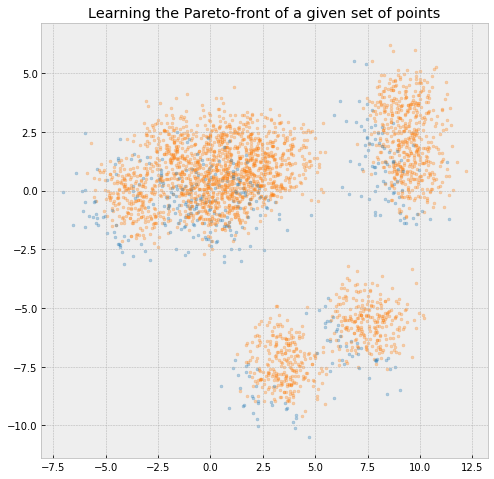

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:1000], Y_train[:100])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.', alpha=0.3)
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.', alpha=0.3)
plt.title("Learning the Pareto-front of a given set of points")
#plt.savefig('globular.png')

(-1.5, 1.5)

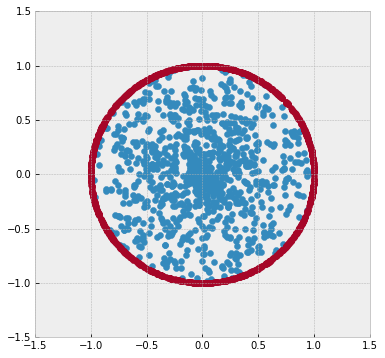

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
n = 1000
a = np.random.randn(n, 2)
u = np.random.uniform(size=n)[:, None]
b = a / np.linalg.norm(a, ord=2, axis=1)[:, None]
c = b * u
#ax.scatter(a[:, 0], a[:, 1])
ax.scatter(c[:, 0], c[:, 1])
ax.scatter(b[:, 0], b[:, 1])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [129]:
from yellowfin import YFOptimizer
from keras.optimizers import TFOptimizer

# define your optimizer
opt = TFOptimizer(YFOptimizer())

In [ ]:
tf.nn.weighted_cross_entropy_with_logits(
    targets,
    logits,
    pos_weight,
    name=None
)


In [56]:
import tensorflow as tf
from sklearn.utils import compute_class_weight
def binary_crossentropy(y_true, y_pred):
    loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, 5.)
    return K.mean(loss, axis=-1)
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.

    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.

    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [57]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 128
n_hidden_set_layers = 3
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=1e-10, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=512,
                          loss_function=binary_crossentropy,
                          kernel_regularizer=l2(1e-6),
                          metrics=[binary_accuracy, fmeasure])

In [60]:
from keras.callbacks import TensorBoard, LearningRateScheduler
netname = '{}-{}-{}-{}-{}d-{}o'.format(n_hidden_set_units, n_hidden_set_layers,
                               n_hidden_joint_units, n_hidden_joint_layers, n_features,
                               n_objects)
tb = TensorBoard(log_dir='/home/kiudee/git/cs-ranking/logs/{}'.format(netname))
tb.__name__ = 'TensorBoard'

def trapezoidal(epoch):
    low_lr = 1e-10
    high_lr = 1e-1
    epochs_ramp_up = 15
    epochs_explore = 60
    epochs_ramp_down = 50
    if epoch <= epochs_ramp_up:
        p = epoch / epochs_ramp_up
        return p * high_lr + (1-p) * low_lr
    elif epoch > epochs_ramp_up and epoch < epochs_explore + epochs_ramp_up:
        return high_lr
    else:
        p = (epoch - epochs_explore - epochs_ramp_up) / epochs_ramp_down
        return min(p * low_lr + (1-p) * high_lr, high_lr)
lr = LearningRateScheduler(trapezoidal)
lr.__name__ = 'LRScheduler'

In [61]:
fate.fit(X_train, Y_train, verbose=False, epochs=140, log_callbacks=[tb, lr])

In [44]:
fate.fit(X_train, Y_train, verbose=False, epochs=10, log_callbacks=[tb],
         optimizer=SGD(lr=1e-6, momentum=0.9, nesterov=True))

In [28]:
X_test, Y_test = make_randn_pareto_choices(n_inst=10000, n_objects=n_objects,
                                           n_features=n_features)

In [127]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.5703
Micro F1 measure: 0.5705
Subset Accuracy: 0.0938


In [43]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.0000
Micro F1 measure: 0.0000
Subset Accuracy: 0.0000


/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
